In [1]:
# Large amount of credit goes to:
# https://www.kaggle.com/jadeblue/dog-generator-starter-eda-preprocessing
# https://github.com/taki0112/Self-Attention-GAN-Tensorflow
# https://www.kaggle.com/amanooo/wgan-gp-keras

from __future__ import print_function, division
import matplotlib.pyplot as plt
import sys
import numpy as np
import pandas as pd
import scipy.misc
from PIL import Image
import os
import glob
import math
import random
import time
import datetime
import shutil
from collections import defaultdict
from keras.preprocessing.image import image
from tqdm import tqdm, tqdm_notebook
import xml.etree.ElementTree as ET 
import cv2
import argparse
import tensorflow as tf
import tensorflow.contrib as tf_contrib
from tensorflow.contrib.data import prefetch_to_device
%matplotlib inline


Using TensorFlow backend.


Created label dictionary for input images.
Total amount of dog breeds:  120
Total amount of input images:  20579


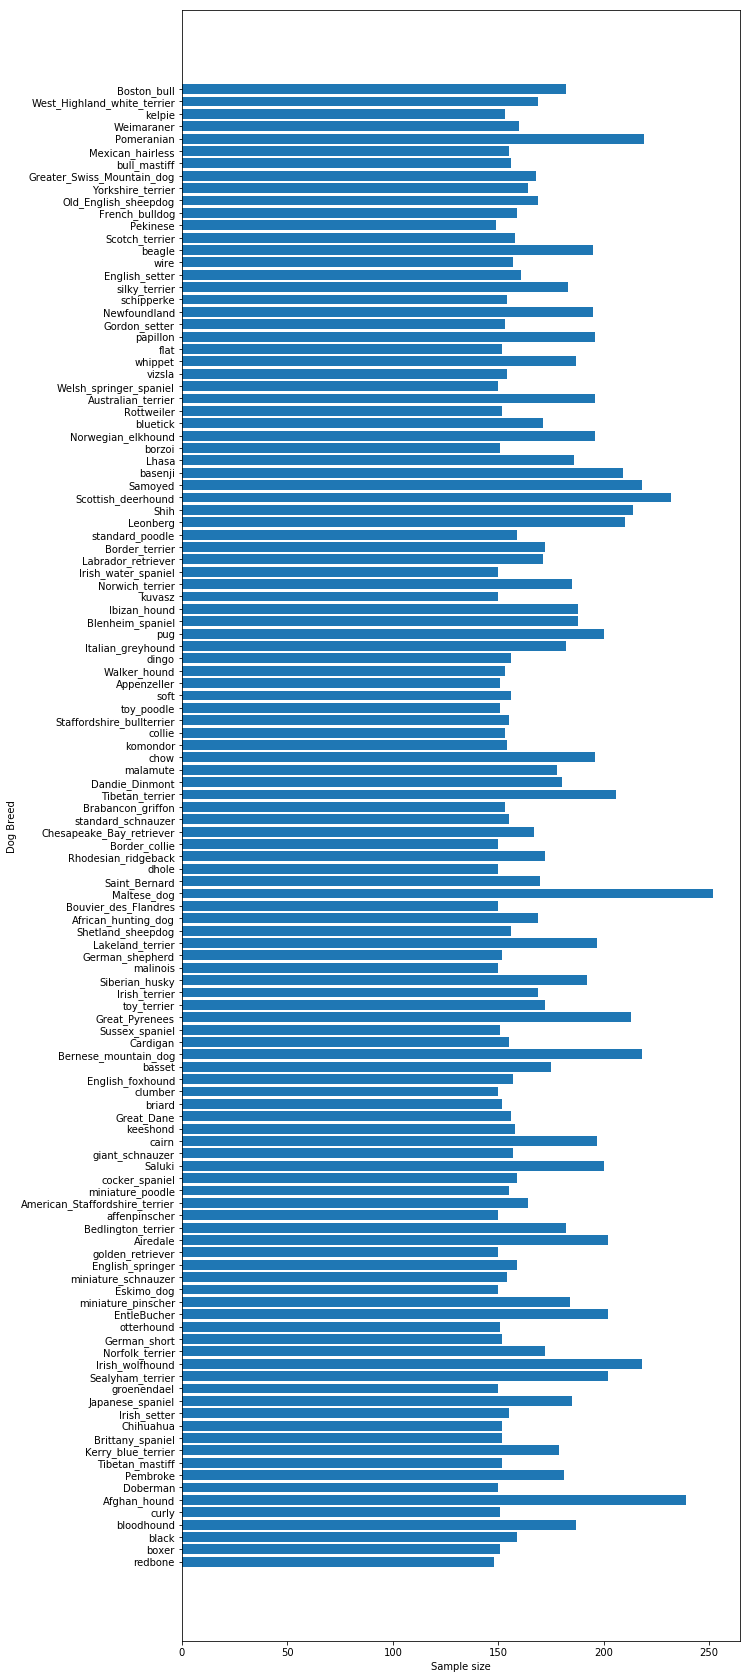

100%|██████████| 156/156 [00:00<00:00, 174.02it/s]


Feature loading time: 0:02:02.
Loaded features shape:  (22125, 64, 64, 3)
Loaded labels:  (22125, 1)


In [2]:
image_width = 64
image_height = 64
image_channels = 3
image_sample_size = 25000

image_input_dir = '../input/all-dogs/all-dogs/'
image_ann_dir = "../input/annotation/Annotation/"

dog_breed_dict = {}
for annotation in os.listdir(image_ann_dir):
    annotations = annotation.split('-')
    dog_breed_dict[annotations[0]] = annotations[1]
    
def get_input_image_dict(image_input_dir, labels_dict):
    image_sample_dict = defaultdict(list)
    for image in os.listdir(image_input_dir):
        filename = image.split('.')
        label_code = filename[0].split('_')[0]
        breed_name = labels_dict[label_code]
        #print('Code: {}, Breed: {}'.format(label_code, breed_name))
        if image is not None:
            image_sample_dict[breed_name].append(image)
    
    print('Created label dictionary for input images.')
    return image_sample_dict

image_sample_dict = get_input_image_dict(image_input_dir, dog_breed_dict)

def plot_class_distributions(image_sample_dict, title=''):
    class_lengths = []
    labels = []
    total_images = 0
    
    print('Total amount of dog breeds: ', len(image_sample_dict))
    
    for label, _ in image_sample_dict.items():
        total_images += len(image_sample_dict[label])
        class_lengths.append(len(image_sample_dict[label]))
        labels.append(label)
        
    print('Total amount of input images: ', total_images)
        
    plt.figure(figsize = (10,30))
    plt.barh(range(len(class_lengths)), class_lengths)
    plt.yticks(range(len(labels)), labels)
    plt.title(title)
    plt.ylabel('Dog Breed')
    plt.xlabel('Sample size')
    plt.show()
    
    return total_images

total_images = plot_class_distributions(image_sample_dict)

def read_image(src):
    img = cv2.imread(src)
    if img is None:
        raise FileNotFoundError
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

def plot_images(directory, image_sample_dict, examples=25, disp_labels=True): 
  
    if not math.sqrt(examples).is_integer():
        print('Please select a valid number of examples.')
        return
    
    imgs = []
    classes = []
    for i in range(examples):
        rnd_class, _ = random.choice(list(image_sample_dict.items()))
        #print(rnd_class)
        rnd_idx = np.random.randint(0, len(image_sample_dict[rnd_class]))
        filename = image_sample_dict[rnd_class][rnd_idx]
        img = read_image(os.path.join(directory, filename))
        imgs.append(img)
        classes.append(rnd_class)
    
    
    fig, axes = plt.subplots(round(math.sqrt(examples)), round(math.sqrt(examples)),figsize=(15,15),
    subplot_kw = {'xticks':[], 'yticks':[]},
    gridspec_kw = dict(hspace=0.3, wspace=0.1))
    
    for i, ax in enumerate(axes.flat):
        if disp_labels == True:
            ax.title.set_text(classes[i])
        ax.imshow(imgs[i])
        
# plot_images(image_input_dir, image_sample_dict)

# plot_images(image_input_dir, image_sample_dict, examples=36, disp_labels=True)

def load_cropped_images(dog_breed_dict=dog_breed_dict, image_ann_dir=image_ann_dir, sample_size=25000, 
                        image_width=image_width, image_height=image_height, image_channels=image_channels):
    curIdx = 0
    breeds = []
    dog_images_np = np.zeros((sample_size,image_width,image_height,image_channels))
    for breed_folder in os.listdir(image_ann_dir):
        for dog_ann in tqdm(os.listdir(image_ann_dir + breed_folder)):
            try:
                img = read_image(os.path.join(image_input_dir, dog_ann + '.jpg'))
            except FileNotFoundError:
                continue
                
            tree = ET.parse(os.path.join(image_ann_dir + breed_folder, dog_ann))
            root = tree.getroot()
            
            size = root.find('size')
            width = int(size.find('width').text)
            height = int(size.find('height').text)
            objects = root.findall('object')
            for o in objects:
                bndbox = o.find('bndbox') 
                
                xmin = int(bndbox.find('xmin').text)
                ymin = int(bndbox.find('ymin').text)
                xmax = int(bndbox.find('xmax').text)
                ymax = int(bndbox.find('ymax').text)
                
                xmin = max(0, xmin - 4)        # 4 : margin
                xmax = min(width, xmax + 4)
                ymin = max(0, ymin - 4)
                ymax = min(height, ymax + 4)

                w = np.min((xmax - xmin, ymax - ymin))
                w = min(w, width, height)                     # available w

                if w > xmax - xmin:
                    xmin = min(max(0, xmin - int((w - (xmax - xmin))/2)), width - w)
                    xmax = xmin + w
                if w > ymax - ymin:
                    ymin = min(max(0, ymin - int((w - (ymax - ymin))/2)), height - w)
                    ymax = ymin + w
                
                img_cropped = img[ymin:ymin+w, xmin:xmin+w, :]      # [h,w,c]
                # Interpolation method
                if xmax - xmin > image_width:
                    interpolation = cv2.INTER_AREA          # shrink
                else:
                    interpolation = cv2.INTER_CUBIC         # expansion
                    
                img_cropped = cv2.resize(img_cropped, (image_width, image_height), 
                                         interpolation=interpolation)  # resize
                    
                dog_images_np[curIdx,:,:,:] = np.asarray(img_cropped)
                dog_breed_name = dog_breed_dict[dog_ann.split('_')[0]]
                breeds.append(dog_breed_name)
                curIdx += 1
    breeds = np.array(breeds).reshape(-1, 1)
    dog_images_np = (dog_images_np- 127.5) / 127.5  # change the pixel range to [-1, 1]

    return dog_images_np, breeds

start_time = time.time()
dog_images_np, breeds = load_cropped_images()
dog_images_np = dog_images_np[:breeds.shape[0],:,:,:]
est_time = round(time.time() - start_time)
print("Feature loading time: {}.".format(str(datetime.timedelta(seconds=est_time))))

print('Loaded features shape: ', dog_images_np.shape)
print('Loaded labels: ', breeds.shape)

In [3]:
class SAGAN(object):

    def __init__(self, sess, epoch, batch_size, iteration, data):
        self.model_name = "SAGAN"  # name for checkpoint
        self.sess = sess
        self.image_output_dir = '../output_images/'
        
        self.epoch = epoch
        self.batch_size = batch_size
        self.iteration = iteration
        self.img_size = 64

        """ Generator """
        self.layer_num = int(np.log2(self.img_size)) - 3
        self.z_dim = 128  # dimension of noise-vector
        self.gan_type = 'gan'

        """ Discriminator """
        self.n_critic = 5
        self.sn = True
        self.ld = 10.0


        self.sample_num = 100  # number of generated images to be saved

        # train
        self.g_learning_rate = 0.0001
        self.d_learning_rate = 0.0004
        self.beta1 = 0.0
        self.beta2 = 0.9
        
        self.data = data
        self.c_dim = self.data.shape[3]
        self.dataset_num = len(self.data)

        print()

        print("##### Information #####")
        print("# gan type : ", self.gan_type)
        print("# dataset number : ", self.dataset_num)
        print("# data channel number : ", self.c_dim) 
        print("# batch_size : ", self.batch_size)
        print("# epoch : ", self.epoch)
        print("# iteration per epoch : ", self.iteration)

        print()

        print("##### Generator #####")
        print("# generator layer : ", self.layer_num)

        print()

        print("##### Discriminator #####")
        print("# discriminator layer : ", self.layer_num)
        print("# the number of critic : ", self.n_critic)
        print("# spectral normalization : ", self.sn)

        # Xavier : tf_contrib.layers.xavier_initializer()
        # He : tf_contrib.layers.variance_scaling_initializer()
        # Normal : tf.random_normal_initializer(mean=0.0, stddev=0.02)
        # l2_decay : tf_contrib.layers.l2_regularizer(0.0001)

        self.weight_init = tf_contrib.layers.xavier_initializer()
        self.weight_regularizer = None
        self.weight_regularizer_fully = None

    ##################################################################################
    # Layer
    ##################################################################################

    def conv(self, x, channels, kernel=4, stride=2, pad=0, pad_type='zero', use_bias=True, sn=False, scope='conv_0'):
        with tf.variable_scope(scope):
            if pad > 0:
                h = x.get_shape().as_list()[1]
                if h % stride == 0:
                    pad = pad * 2
                else:
                    pad = max(kernel - (h % stride), 0)

                pad_top = pad // 2
                pad_bottom = pad - pad_top
                pad_left = pad // 2
                pad_right = pad - pad_left

                if pad_type == 'zero':
                    x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]])
                if pad_type == 'reflect':
                    x = tf.pad(x, [[0, 0], [pad_top, pad_bottom], [pad_left, pad_right], [0, 0]], mode='REFLECT')

            if sn:
                w = tf.get_variable("kernel", shape=[kernel, kernel, x.get_shape()[-1], channels], initializer=self.weight_init,
                                    regularizer=self.weight_regularizer)
                x = tf.nn.conv2d(input=x, filter=self.spectral_norm(w),
                                 strides=[1, stride, stride, 1], padding='VALID')
                if use_bias:
                    bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                    x = tf.nn.bias_add(x, bias)

            else:
                x = tf.layers.conv2d(inputs=x, filters=channels,
                                     kernel_size=kernel, kernel_initializer=self.weight_init,
                                     kernel_regularizer=self.weight_regularizer,
                                     strides=stride, use_bias=use_bias)

            return x


    def deconv(self, x, channels, kernel=4, stride=2, padding='SAME', use_bias=True, sn=False, scope='deconv_0'):
        with tf.variable_scope(scope):
            x_shape = x.get_shape().as_list()

            if padding == 'SAME':
                output_shape = [x_shape[0], x_shape[1] * stride, x_shape[2] * stride, channels]

            else:
                output_shape = [x_shape[0], x_shape[1] * stride + max(kernel - stride, 0),
                                x_shape[2] * stride + max(kernel - stride, 0), channels]

            if sn:
                w = tf.get_variable("kernel", shape=[kernel, kernel, channels, x.get_shape()[-1]], initializer=self.weight_init,
                                    regularizer=self.weight_regularizer)
                x = tf.nn.conv2d_transpose(x, filter=self.spectral_norm(w), output_shape=output_shape,
                                           strides=[1, stride, stride, 1], padding=padding)

                if use_bias:
                    bias = tf.get_variable("bias", [channels], initializer=tf.constant_initializer(0.0))
                    x = tf.nn.bias_add(x, bias)

            else:
                x = tf.layers.conv2d_transpose(inputs=x, filters=channels,
                                               kernel_size=kernel, kernel_initializer=self.weight_init,
                                               kernel_regularizer=self.weight_regularizer,
                                               strides=stride, padding=padding, use_bias=use_bias)

            return x

    def fully_connected(self, x, units, use_bias=True, sn=False, scope='linear'):
        with tf.variable_scope(scope):
            x = self.flatten(x)
            shape = x.get_shape().as_list()
            channels = shape[-1]

            if sn:
                w = tf.get_variable("kernel", [channels, units], tf.float32,
                                    initializer=self.weight_init, regularizer=self.weight_regularizer_fully)
                if use_bias:
                    bias = tf.get_variable("bias", [units],
                                           initializer=tf.constant_initializer(0.0))

                    x = tf.matmul(x, self.spectral_norm(w)) + bias
                else:
                    x = tf.matmul(x, self.spectral_norm(w))

            else:
                x = tf.layers.dense(x, units=units, kernel_initializer=self.weight_init,
                                    kernel_regularizer=self.weight_regularizer_fully,
                                    use_bias=use_bias)

            return x

    def flatten(self, x) :
        return tf.layers.flatten(x)

    def hw_flatten(self, x) :
        return tf.reshape(x, shape=[x.shape[0], -1, x.shape[-1]])

    ##################################################################################
    # Residual-block
    ##################################################################################

    def up_resblock(self, x_init, channels, use_bias=True, is_training=True, sn=False, scope='resblock'):
        with tf.variable_scope(scope):
            with tf.variable_scope('res1'):
                x = self.batch_norm(x_init, is_training)
                x = self.relu(x)
                x = self.up_sample(x, scale_factor=2)
                x = self.conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=False, sn=sn)

            with tf.variable_scope('res2'):
                x = self.batch_norm(x, is_training)
                x = self.relu(x)
                x = self.conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

            with tf.variable_scope('shortcut'):
                x_init = self.up_sample(x_init, scale_factor=2)
                x_init = self.conv(x_init, channels, kernel=1, stride=1, use_bias=False, sn=sn)

            return x + x_init

    def down_resblock(self, x_init, channels, to_down=True, use_bias=True, sn=False, scope='resblock'):
        with tf.variable_scope(scope):
            init_channel = x_init.shape.as_list()[-1]
            with tf.variable_scope('res1'):
                x = self.lrelu(x_init, 0.2)
                x = self.conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

            with tf.variable_scope('res2'):
                x = self.lrelu(x, 0.2)
                x = self.conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)

                if to_down :
                    x = self.down_sample(x)

            if to_down or init_channel != channels :
                with tf.variable_scope('shortcut'):
                    x_init = self.conv(x_init, channels, kernel=1, stride=1, use_bias=use_bias, sn=sn)
                    if to_down :
                        x_init = self.down_sample(x_init)


            return x + x_init

    def init_down_resblock(self, x_init, channels, use_bias=True, sn=False, scope='resblock'):
        with tf.variable_scope(scope):
            with tf.variable_scope('res1'):
                x = self.conv(x_init, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)
                x = self.lrelu(x, 0.2)

            with tf.variable_scope('res2'):
                x = self.conv(x, channels, kernel=3, stride=1, pad=1, pad_type='reflect', use_bias=use_bias, sn=sn)
                x = self.down_sample(x)

            with tf.variable_scope('shortcut'):
                x_init = self.down_sample(x_init)
                x_init = self.conv(x_init, channels, kernel=1, stride=1, use_bias=use_bias, sn=sn)

            return x + x_init

    ##################################################################################
    # Sampling
    ##################################################################################

    def global_avg_pooling(self, x):
        gap = tf.reduce_mean(x, axis=[1, 2])

        return gap

    def global_sum_pooling(self, x) :
        gsp = tf.reduce_sum(x, axis=[1, 2])

        return gsp

    def up_sample(self, x, scale_factor=2):
        _, h, w, _ = x.get_shape().as_list()
        new_size = [h * scale_factor, w * scale_factor]
        return tf.image.resize_nearest_neighbor(x, size=new_size)

    def down_sample(self, x):
        return tf.layers.average_pooling2d(x, pool_size=2, strides=2, padding='SAME')

    def max_pooling(self, x) :
        return tf.layers.max_pooling2d(x, pool_size=2, strides=2, padding='SAME')

    ##################################################################################
    # Activation function
    ##################################################################################

    def lrelu(self, x, alpha=0.2):
        return tf.nn.leaky_relu(x, alpha)


    def relu(self, x):
        return tf.nn.relu(x)


    def tanh(self, x):
        return tf.tanh(x)

    ##################################################################################
    # Normalization function
    ##################################################################################

    def batch_norm(self, x, is_training=True, scope='batch_norm'):
        return tf_contrib.layers.batch_norm(x,
                                            decay=0.9, epsilon=1e-05,
                                            center=True, scale=True, updates_collections=None,
                                            is_training=is_training, scope=scope)

    def spectral_norm(self, w, iteration=1):
        w_shape = w.shape.as_list()
        w = tf.reshape(w, [-1, w_shape[-1]])

        u = tf.get_variable("u", [1, w_shape[-1]], initializer=tf.random_normal_initializer(), trainable=False)

        u_hat = u
        v_hat = None
        for i in range(iteration):
            """
            power iteration
            Usually iteration = 1 will be enough
            """
            v_ = tf.matmul(u_hat, tf.transpose(w))
            v_hat = tf.nn.l2_normalize(v_)

            u_ = tf.matmul(v_hat, w)
            u_hat = tf.nn.l2_normalize(u_)

        u_hat = tf.stop_gradient(u_hat)
        v_hat = tf.stop_gradient(v_hat)

        sigma = tf.matmul(tf.matmul(v_hat, w), tf.transpose(u_hat))

        with tf.control_dependencies([u.assign(u_hat)]):
            w_norm = w / sigma
            w_norm = tf.reshape(w_norm, w_shape)

        return w_norm

    ##################################################################################
    # Loss function
    ##################################################################################

    def discriminator_loss(self, loss_func, real, fake):
        real_loss = 0
        fake_loss = 0

        if loss_func.__contains__('wgan') :
            real_loss = -tf.reduce_mean(real)
            fake_loss = tf.reduce_mean(fake)

        if loss_func == 'lsgan' :
            real_loss = tf.reduce_mean(tf.squared_difference(real, 1.0))
            fake_loss = tf.reduce_mean(tf.square(fake))

        if loss_func == 'gan' or loss_func == 'dragan' :
            real_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(real), logits=real))
            fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.zeros_like(fake), logits=fake))

        if loss_func == 'hinge' :
            real_loss = tf.reduce_mean(self.relu(1.0 - real))
            fake_loss = tf.reduce_mean(self.relu(1.0 + fake))

        loss = real_loss + fake_loss

        return loss

    def generator_loss(self, loss_func, fake):
        fake_loss = 0

        if loss_func.__contains__('wgan') :
            fake_loss = -tf.reduce_mean(fake)

        if loss_func == 'lsgan' :
            fake_loss = tf.reduce_mean(tf.squared_difference(fake, 1.0))

        if loss_func == 'gan' or loss_func == 'dragan' :
            fake_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(labels=tf.ones_like(fake), logits=fake))

        if loss_func == 'hinge' :
            fake_loss = -tf.reduce_mean(fake)

        loss = fake_loss

        return loss
    
    ##################################################################################
    # Generator
    ##################################################################################

    def generator(self, z, is_training=True, reuse=False):
        with tf.variable_scope("generator", reuse=reuse):
            ch = 1024
            x = self.fully_connected(z, units=4 * 4 * ch, sn=self.sn, scope='fc')
            x = tf.reshape(x, [-1, 4, 4, ch])

            x = self.up_resblock(x, channels=ch, is_training=is_training, sn=self.sn, scope='front_resblock_0')

            for i in range(self.layer_num // 2) :
                x = self.up_resblock(x, channels=ch // 2, is_training=is_training, sn=self.sn, scope='middle_resblock_' + str(i))
                ch = ch // 2

            x = self.google_attention(x, channels=ch, scope='self_attention')

            for i in range(self.layer_num // 2, self.layer_num) :
                x = self.up_resblock(x, channels=ch // 2, is_training=is_training, sn=self.sn, scope='back_resblock_' + str(i))
                ch = ch // 2

            x = self.batch_norm(x, is_training)
            x = self.relu(x)

            x = self.conv(x, channels=self.c_dim, kernel=3, stride=1, pad=1, pad_type='reflect', scope='g_logit')
            x = self.tanh(x)

            return x

    ##################################################################################
    # Discriminator
    ##################################################################################

    def discriminator(self, x, reuse=False):
        with tf.variable_scope("discriminator", reuse=reuse):
            ch = 64

            x = self.init_down_resblock(x, channels=ch, sn=self.sn, scope='init_resblock')

            x = self.down_resblock(x, channels=ch * 2, sn=self.sn, scope='front_down_resblock')
            x = self.google_attention(x, channels=ch * 2, scope='self_attention')

            ch = ch * 2

            for i in range(self.layer_num) :
                if i == self.layer_num - 1 :
                    x = self.down_resblock(x, channels=ch, sn=self.sn, to_down=False, scope='middle_down_resblock_' + str(i))
                else :
                    x = self.down_resblock(x, channels=ch * 2, sn=self.sn, scope='middle_down_resblock_' + str(i))

                ch = ch * 2

            x = self.lrelu(x, 0.2)

            x = self.global_sum_pooling(x)

            x = self.fully_connected(x, units=1, sn=self.sn, scope='d_logit')

            return x

    def attention(self, x, channels, scope='attention'):
        with tf.variable_scope(scope):
            f = self.conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='f_conv') # [bs, h, w, c']
            g = self.conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='g_conv') # [bs, h, w, c']
            h = self.conv(x, channels, kernel=1, stride=1, sn=self.sn, scope='h_conv') # [bs, h, w, c]

            # N = h * w
            s = tf.matmul(self.hw_flatten(g), self.hw_flatten(f), transpose_b=True) # # [bs, N, N]

            beta = tf.nn.softmax(s)  # attention map

            o = tf.matmul(beta, self.hw_flatten(h)) # [bs, N, C]
            gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

            o = tf.reshape(o, shape=x.shape) # [bs, h, w, C]
            o = self.conv(o, channels, kernel=1, stride=1, sn=self.sn, scope='attn_conv')

            x = gamma * o + x

        return x

    def google_attention(self, x, channels, scope='attention'):
        with tf.variable_scope(scope):
            batch_size, height, width, num_channels = x.get_shape().as_list()
            f = self.conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='f_conv')  # [bs, h, w, c']
            f = self.max_pooling(f)

            g = self.conv(x, channels // 8, kernel=1, stride=1, sn=self.sn, scope='g_conv')  # [bs, h, w, c']

            h = self.conv(x, channels // 2, kernel=1, stride=1, sn=self.sn, scope='h_conv')  # [bs, h, w, c]
            h = self.max_pooling(h)

            # N = h * w
            s = tf.matmul(self.hw_flatten(g), self.hw_flatten(f), transpose_b=True)  # # [bs, N, N]

            beta = tf.nn.softmax(s)  # attention map

            o = tf.matmul(beta, self.hw_flatten(h))  # [bs, N, C]
            gamma = tf.get_variable("gamma", [1], initializer=tf.constant_initializer(0.0))

            o = tf.reshape(o, shape=[batch_size, height, width, num_channels // 2])  # [bs, h, w, C]
            o = self.conv(o, channels, kernel=1, stride=1, sn=self.sn, scope='attn_conv')
            x = gamma * o + x

        return x

    def gradient_penalty(self, real, fake):
        if self.gan_type == 'dragan' :
            shape = tf.shape(real)
            eps = tf.random_uniform(shape=shape, minval=0., maxval=1.)
            x_mean, x_var = tf.nn.moments(real, axes=[0, 1, 2, 3])
            x_std = tf.sqrt(x_var)  # magnitude of noise decides the size of local region
            noise = 0.5 * x_std * eps  # delta in paper

            # Author suggested U[0,1] in original paper, but he admitted it is bug in github
            # (https://github.com/kodalinaveen3/DRAGAN). It should be two-sided.

            alpha = tf.random_uniform(shape=[shape[0], 1, 1, 1], minval=-1., maxval=1.)
            interpolated = tf.clip_by_value(real + alpha * noise, -1., 1.)  # x_hat should be in the space of X

        else :
            alpha = tf.random_uniform(shape=[self.batch_size, 1, 1, 1], minval=0., maxval=1.)
            interpolated = alpha*real + (1. - alpha)*fake

        logit = self.discriminator(interpolated, reuse=True)

        grad = tf.gradients(logit, interpolated)[0]  # gradient of D(interpolated)
        grad_norm = tf.norm(self.flatten(grad), axis=1)  # l2 norm

        GP = 0

        # WGAN - LP
        if self.gan_type == 'wgan-lp':
            GP = self.ld * tf.reduce_mean(tf.square(tf.maximum(0.0, grad_norm - 1.)))

        elif self.gan_type == 'wgan-gp' or self.gan_type == 'dragan':
            GP = self.ld * tf.reduce_mean(tf.square(grad_norm - 1.))

        return GP

    ##################################################################################
    # Model
    ##################################################################################

    def build_model(self):
        """ Graph Input """
        # images
        self.inputs = tf.placeholder(tf.float32, [self.batch_size, self.img_size, self.img_size, self.c_dim], name='real_images')

        # noises
        self.z = tf.placeholder(tf.float32, [self.batch_size, 1, 1, self.z_dim], name='z')

        """ Loss Function """
        # output of D for real images
        real_logits = self.discriminator(self.inputs)

        # output of D for fake images
        fake_images = self.generator(self.z)
        fake_logits = self.discriminator(fake_images, reuse=True)

        if self.gan_type.__contains__('wgan') or self.gan_type == 'dragan' :
            GP = self.gradient_penalty(real=self.inputs, fake=fake_images)
        else :
            GP = 0

        # get loss for discriminator
        self.d_loss = self.discriminator_loss(self.gan_type, real=real_logits, fake=fake_logits) + GP

        # get loss for generator
        self.g_loss = self.generator_loss(self.gan_type, fake=fake_logits)

        """ Training """
        # divide trainable variables into a group for D and a group for G
        t_vars = tf.trainable_variables()
        d_vars = [var for var in t_vars if 'discriminator' in var.name]
        g_vars = [var for var in t_vars if 'generator' in var.name]

        # optimizers
        self.d_optim = tf.train.AdamOptimizer(self.d_learning_rate, beta1=self.beta1, beta2=self.beta2).minimize(self.d_loss, var_list=d_vars)
        self.g_optim = tf.train.AdamOptimizer(self.g_learning_rate, beta1=self.beta1, beta2=self.beta2).minimize(self.g_loss, var_list=g_vars)

        """" Testing """
        # for test
        self.fake_images = self.generator(self.z, is_training=False, reuse=True)

        """ Summary """
        self.d_sum = tf.summary.scalar("d_loss", self.d_loss)
        self.g_sum = tf.summary.scalar("g_loss", self.g_loss)

    ##################################################################################
    # Train
    ##################################################################################

    def train(self):
        # initialize all variables
        tf.global_variables_initializer().run()

        # graph inputs for visualize training results
        self.sample_z = np.random.uniform(-1, 1, size=(self.batch_size, 1, 1, self.z_dim))

        # saver to save model
        self.saver = tf.train.Saver()
        
        start_epoch = 0
        start_batch_id = 0
        counter = 1
        # loop for epoch
        start_time = time.time()
        past_g_loss = -1.
        for epoch in range(start_epoch, self.epoch):
            # get batch data
            for idx in range(start_batch_id, self.iteration):
                batch_z = np.random.uniform(-1, 1, [self.batch_size, 1, 1, self.z_dim])
                random_index = np.random.choice(self.dataset_num, size=self.batch_size, replace=False)
                # batch_images = self.data[idx*self.batch_size : (idx+1)*self.batch_size]
                batch_images = self.data[random_index]

                train_feed_dict = {
                    self.inputs : batch_images,
                    self.z : batch_z
                }

                # update D network
                _, summary_str, d_loss = self.sess.run([self.d_optim, self.d_sum, self.d_loss], feed_dict=train_feed_dict)

                # update G network
                g_loss = None
                if (counter - 1) % self.n_critic == 0:
                    _, summary_str, g_loss = self.sess.run([self.g_optim, self.g_sum, self.g_loss], feed_dict=train_feed_dict)
                    past_g_loss = g_loss

                # display training status
                counter += 1
                if g_loss == None :
                    g_loss = past_g_loss
                    
                if np.mod(idx+1, 100) == 0:    
                    print("Epoch: [%2d] [%5d/%5d] time: %4.4f, d_loss: %.8f, g_loss: %.8f" \
                      % (epoch, idx, self.iteration, time.time() - start_time, d_loss, g_loss))

#             #training results for every epoch
#             samples = self.sess.run(self.fake_images, feed_dict={self.z: self.sample_z})
#             self.save_imgs(samples, epoch)

            # After an epoch, start_batch_id is set to zero
            # non-zero value is only for the first epoch after loading pre-trained model
            start_batch_id = 0
            
#     def save_imgs(self, gen_imgs, epoch):
#         r, c = 8, 4
#         # Rescale images 0 - 1
#         gen_imgs = 0.5 * gen_imgs + 0.5

#         fig, axs = plt.subplots(r, c)
#         cnt = 0
#         for i in range(r):
#             for j in range(c):
#                 axs[i,j].imshow(gen_imgs[cnt, :,:,:], cmap=plt.get_cmap('CMRmap'))
#                 axs[i,j].axis('off')
#                 cnt += 1
#         fig.savefig("images/dog_%d.png" % epoch)
#         plt.close()

            
    def sumple_images(self, imgs, rows, cols, figsize):
        fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=figsize)
        for indx, axis in enumerate(axes.flatten()):
            img = image.array_to_img(imgs[indx])    # ndarray → PIL
            imgplot = axis.imshow(img)
            axis.set_axis_off()
        plt.tight_layout()

    def submit_imgs(self, n_images):      

        if os.path.exists(self.image_output_dir):
            shutil.rmtree(self.image_output_dir)
        if not os.path.exists(self.image_output_dir):
            os.mkdir(self.image_output_dir)
        
        gensize = n_images
        if n_images % self.batch_size > 0:
            gensize = (n_images // self.batch_size + 1) * self.batch_size
        for i in tqdm(range(0, gensize, self.batch_size)):
            
            z_sample = np.random.uniform(-1, 1, size=(self.batch_size, 1, 1, self.z_dim))

            gen_imgs = self.sess.run(self.fake_images, feed_dict={self.z: z_sample})
                        
            imgs = gen_imgs * 127.5 + 127.5
            for j in range(self.batch_size):
                img = image.array_to_img(imgs[j])      # ndarray → PIL 
                img.save(os.path.join(self.image_output_dir, 'image_' + str(i+j+1).zfill(5) + '.png'))
                if i+j+1 == n_images:
                    break
        print(len(os.listdir(self.image_output_dir)))
        
        # generated DOGs sumple
        self.sumple_images(gen_imgs, rows=5, cols=5, figsize=(12,8))
        
        if os.path.exists('images.zip'):
            os.remove('images.zip')
        shutil.make_archive('images', 'zip', self.image_output_dir)
        print("<END>")     



##### Information #####
# gan type :  gan
# dataset number :  22125
# data channel number :  3
# batch_size :  64
# epoch :  300
# iteration per epoch :  400

##### Generator #####
# generator layer :  3

##### Discriminator #####
# discriminator layer :  3
# the number of critic :  5
# spectral normalization :  True
Epoch: [ 0] [   99/  400] time: 34.2508, d_loss: 0.49563453, g_loss: 1.80410051
Epoch: [ 0] [  199/  400] time: 59.6954, d_loss: 0.84929180, g_loss: 1.05349255
Epoch: [ 0] [  299/  400] time: 85.1361, d_loss: 0.33265674, g_loss: 1.86011100
Epoch: [ 0] [  399/  400] time: 110.5873, d_loss: 0.59615910, g_loss: 1.30845678
Epoch: [ 1] [   99/  400] time: 136.0245, d_loss: 0.67721051, g_loss: 0.93890792
Epoch: [ 1] [  199/  400] time: 161.4425, d_loss: 0.31037945, g_loss: 3.02318406
Epoch: [ 1] [  299/  400] time: 186.9032, d_loss: 0.21596949, g_loss: 2.27779865
Epoch: [ 1] [  399/  400] time: 212.3293, d_loss: 0.22875801, g_loss: 2.51121593
Epoch: [ 2] [   99/  400] time: 237

  0%|          | 0/157 [00:00<?, ?it/s]

Epoch: [299] [  399/  400] time: 30525.5405, d_loss: 0.34673581, g_loss: 2.82446885


100%|██████████| 157/157 [00:23<00:00,  7.47it/s]


10000
<END>
 [*] Training finished!


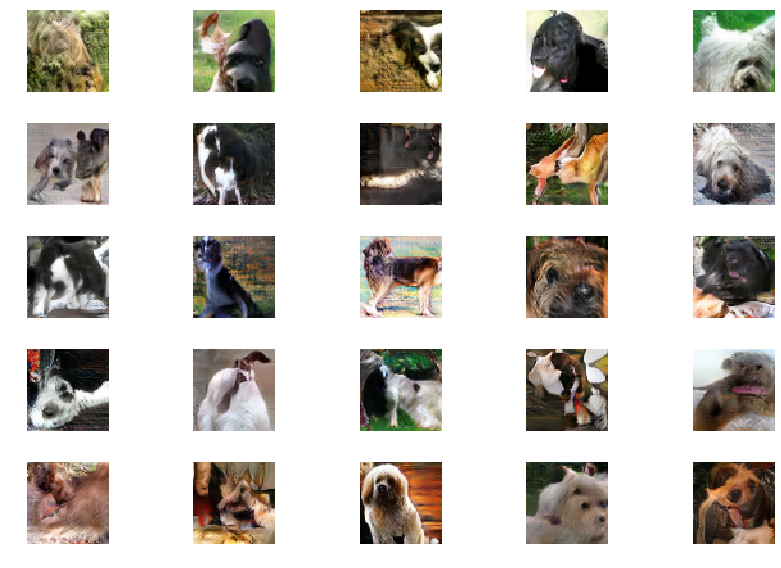

In [4]:
if __name__ == '__main__':
        
    epoch = 300
    batch_size = 64
    iteration = (len(breeds) // batch_size // 100 + 1) * 100
    n_images = 10000
    
    # open session
    with tf.Session(config=tf.ConfigProto(allow_soft_placement=True)) as sess:
        
        gan = SAGAN(sess, epoch, batch_size, iteration, dog_images_np)
        
        # build graph
        gan.build_model()
        
        # launch the graph in a session
        gan.train()
         
        # submit images
        gan.submit_imgs(n_images)

        print(" [*] Training finished!")        